In [2]:
!pip install yfinance




# Загрузка акций по их тикерам( Apple, Walmart, IBM, Visa, Boeing)

In [3]:
import yfinance as yf

import pandas as pd
tickers_list = ['AAPL', 'WMT', 'IBM', 'V', 'BA']

df = pd.DataFrame(columns=tickers_list)


for ticker in tickers_list:
    df[ticker] = yf.download(ticker,'2010-01-02','2021-08-14')['Adj Close']

df.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,WMT,IBM,V,BA
Date,,,,,
2021-08-09,146.089996,145.046249,141.250000,239.673279,232.270004
2021-08-10,145.600006,148.134872,141.380005,237.745911,235.779999
2021-08-11,145.860001,149.459991,142.130005,234.739990,239.490005
2021-08-12,148.889999,149.059998,143.070007,231.789993,238.179993
2021-08-13,149.100006,149.529999,143.179993,232.649994,234.460007


<AxesSubplot:xlabel='Date'>

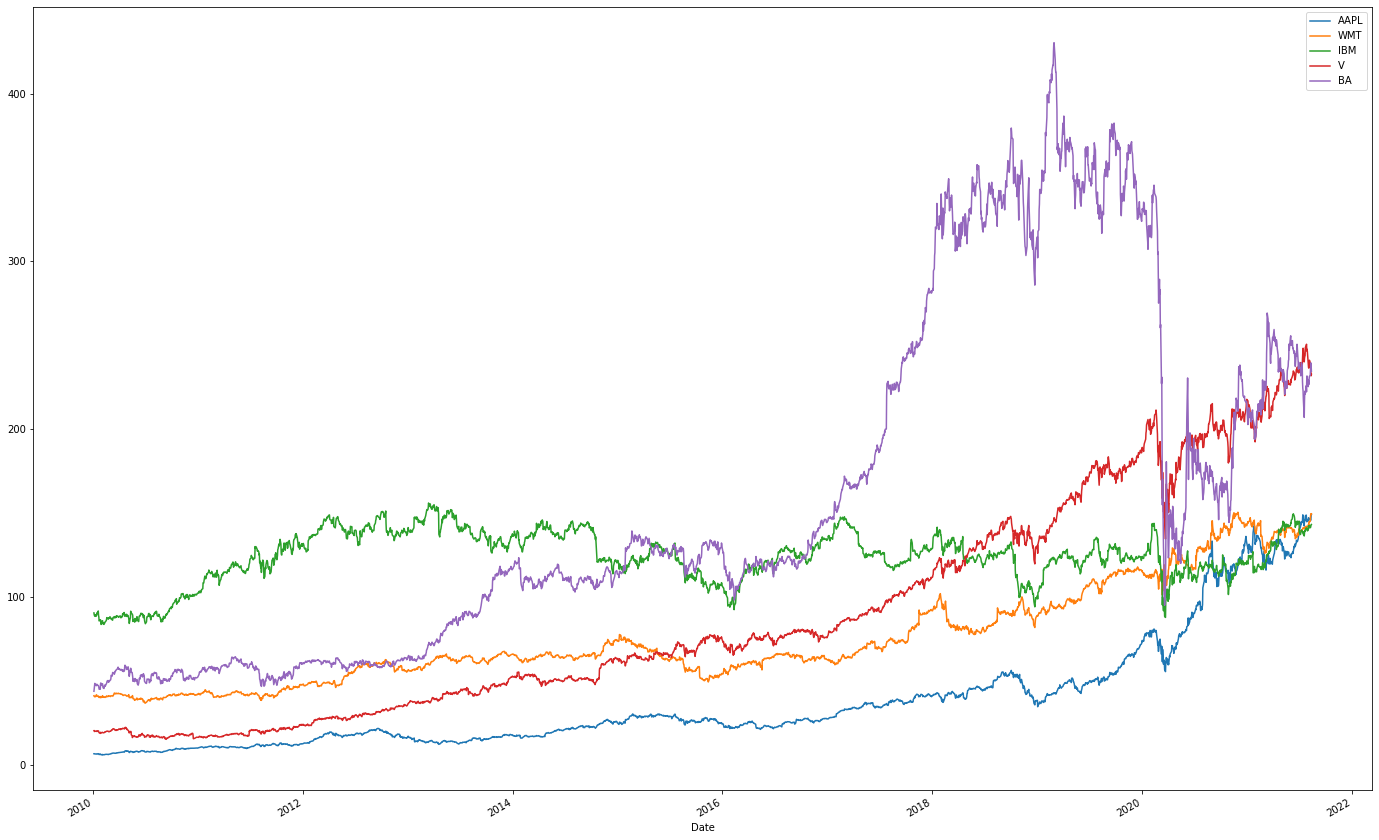

In [4]:
df[[
    'AAPL', 'WMT', 'IBM', 'V', 'BA'
]].plot(figsize=(24, 16))

# Задание тренировочного набора для кроссвалидации и тестового набора для итоговой проверки

In [5]:
window = 252 * 2
df_train = df[:-window]
df_test = df[-window:]

In [31]:
df_train.shape

(2420, 5)

# Реализация алгоритма Олмар

In [6]:
def algoOLMAR(
    df: pd.DataFrame,
    eps,
    a,
) -> pd.Series:
    price_ratio = df.pct_change() + 1  # Отношение цен
    price_ratio.drop(price_ratio.head(1).index, inplace=True)
    b = np.zeros((price_ratio.shape[0] + 1, price_ratio.shape[1]))
    b[0, :] = 1 / (price_ratio.shape[1]) * np.ones(
        price_ratio.shape[1])  #Инициализация равных первоначальных весов
    price_ratio_pred = np.ones(
        price_ratio.shape[1]
    )  #Отношения цен, которые предсказываются как экспоненциально средние
    for t in range(len(price_ratio)):
        price_ratio_pred = a * np.ones(price_ratio_pred.shape[0]) + (
            1 - a) * np.divide(price_ratio_pred, price_ratio.iloc[t, :])
        price_ratio_avg = \
            np.dot(np.ones(price_ratio_pred.shape).T,
                   price_ratio_pred)/df.shape[1]
        lamda = max(0, (eps - np.dot(b[t, :], price_ratio_pred)) /
                    (np.linalg.norm(price_ratio_pred - price_ratio_avg *
                                    np.ones(price_ratio_pred.shape[0])))**
                    2)  # Вычисление множителя ЛАГРАНЖА
        b[t + 1, :] = b[t, :] + lamda * (
            price_ratio_pred -
            price_ratio_avg * np.ones(price_ratio_pred.shape))  # Новые веса
        lam = ((1 / b[t + 1, :].shape[0]) * (1 - sum(b[t + 1, :])))
        vec = lam + b[t +
                      1, :]  # Набор весов после решения оптимизационной задачи
        while sum(vec < 0) > 0:
            vec = ((vec > 0) * vec) + (1 / (sum(vec > 0)) * (1 - sum(
                (vec > 0) * vec))) * (
                    vec >
                    0) * 1  # Нормировка весов с помощью проекции на симплекс

    return vec

In [7]:
def calculate_conditional_drawdown_risk(returns, confidence_level=0.05):
        returns = pd.DataFrame(returns)
        drawdown = returns.expanding().max() - returns
        max_drawdown = drawdown.expanding().max()

        # Используется (1-уровень уверенности), потому что худшие просадки-это самые большие положительные значения
        max_drawdown_at_confidence_level = max_drawdown.quantile(
            1 - confidence_level, interpolation='higher')
        conditional_drawdown = np.nanmean(
            max_drawdown[max_drawdown >= max_drawdown_at_confidence_level])
        return conditional_drawdown



# Кроссвалидация

In [47]:
train_start = 0
train_length = 252
offset = int(63)
test_start = train_start + train_length + offset
test_length = 63
cv_results = dict()
count = 0

cv_list = [x for x in range(df_train.shape[0] - train_start -
                           train_length - offset - test_length)]
for i in cv_list:
    # train df for cv
    df_train_loop = df_train[i:i + train_length].copy()

    # test df for metrics
    train_start = i + train_length + offset
    train_end = (i + train_length + offset +
                                 test_length)
    df_test_loop = df_train[train_start:train_end].copy()
    assets_weights = algoOLMAR(
                        df_train_loop,
                        eps=1.0005,a=0.001
                    )
    df_test_loop=df_test_loop.pct_change()
    ann = 252 / df_test_loop.shape[0]
    ret_ts = np.dot(np.array(assets_weights), df_test_loop.fillna(0).T)
    port_returns = np.cumprod(1 + ret_ts)
    pr = (port_returns[-1] ** ann - 1)
    sr = (pr - 0.04) / (np.std(ret_ts) * np.sqrt(252))
    dd = calculate_conditional_drawdown_risk(ret_ts)
    ratio = pr/dd

    results = {
                            'SR': sr,'Drawdown': dd,
                            'return annualized': pr,'Ratio Return and DD': ratio,
                        }
    cv_results['Fold_' + str(count)] = results
    count += 1


In [48]:
cv_df=pd.DataFrame(cv_results.values())

# Визуализация кроссвалидации

CV means:
return annualized: 22.64%
SR: 1.3
Max Drawdown: 20.00%
Ratio Return and DD: 4.5


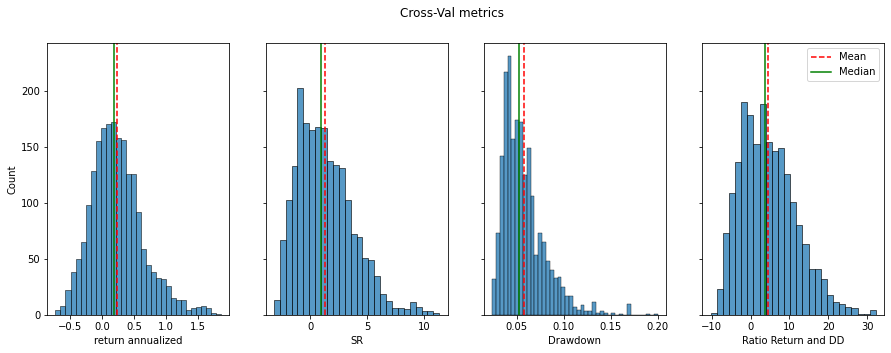

In [49]:

import matplotlib.pyplot as plt
import seaborn as sns


metrics_list=['return annualized','SR','Drawdown', 'Ratio Return and DD']


fig, axes = plt.subplots(1, len(metrics_list),
                             figsize=(15, 5), sharey=True)
fig.suptitle('Cross-Val metrics')
print("CV means:")
for i in range(len(metrics_list)):
    sns.histplot(cv_df[metrics_list[i]], ax=axes[i])
    mean = cv_df[metrics_list[i]].mean()
    median = cv_df[metrics_list[i]].median()
    max_values = cv_df[metrics_list[i]].max()
    axes[i].axvline(mean, color='r', linestyle='--')
    axes[i].axvline(median, color='g', linestyle='-')
    if metrics_list[i] == 'Drawdown':
            print(f"Max {metrics_list[i]}: {max_values:.2%}")
    elif metrics_list[i] == 'SR':
            print(f"{metrics_list[i]}: {mean:.2}")
    elif metrics_list[i] == 'Ratio Return and DD':
            print(f"{metrics_list[i]}: {mean:.2}")
    else:
            print(f"{metrics_list[i]}: {mean:.2%}")
plt.legend({'Mean': mean, 'Median': median})
plt.show()


# Проверка на тесте и вывод активов с весами

portfolio returns for the period: 32.9%
portfolio returns annualized: 15.28%
portfolio Drawdown for the period: 18.27%
portfolio sharpe for the period: 0.462
portfolio ratio returns for the period and MaxDrawdown a: 0.836
portfolio std the period: 0.244
----------------------------------------------------
uniform portfolio returns for the period: 48.2%
uniform portfolio returns annualized: 21.73%
uniform portfolio Drawdown for the period: 22.26%
uniform portfolio sharpe for the period: 0.377
uniform portfolio ratio returns for the period and MaxDrawdown a: 0.976
uniform portfolio std the period: 0.299


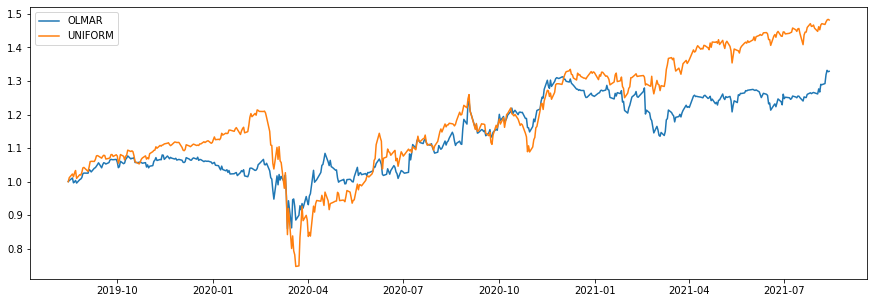

<AxesSubplot:>

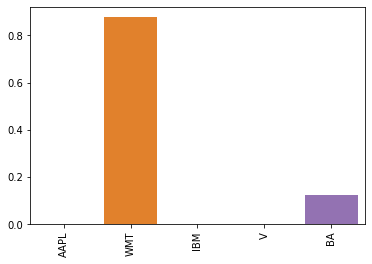

In [46]:
assets_weights_uniform = 1 / (df_test.shape[1]) * np.ones(df_test.shape[1])

assets_weights = algoOLMAR(df_train, 1.0005, 0.001)

ann = 252 / df_test.shape[0]
ret_ts = np.dot(np.array(assets_weights), df_test.pct_change().fillna(0).T)
port_returns = np.cumprod(1 + ret_ts)
pr = (port_returns[-1]**ann - 1)
sr = (pr - 0.04) / (np.std(ret_ts) * np.sqrt(252))
dd = calculate_conditional_drawdown_risk(ret_ts)
ratio = pr / dd

results = {
    'return total': port_returns[-1] - 1,
    'return annualized': pr,
    'Drawdown': dd,
    'SR': sr,
    'Ratio Return and MDD': ratio,
}
print('portfolio returns for the period: {:.1%}'.format(port_returns[-1] - 1))
print('portfolio returns annualized: {:.2%}'.format(pr))
print('portfolio Drawdown for the period: {:.2%}'.format(dd))
print('portfolio sharpe for the period: {:.3f}'.format(sr))
print(
    'portfolio ratio returns for the period and MaxDrawdown a: {:.3f}'.format(
        ratio))

print('portfolio std the period: {:.3f}'.format(np.std(ret_ts) * np.sqrt(252)))

ret_ts_ = np.dot(np.array(assets_weights_uniform),
                 df_test.pct_change().fillna(0).T)
port_returns_ = np.cumprod(1 + ret_ts_)
pr_ = (port_returns_[-1]**ann - 1)
sr_ = (pr - 0.04) / (np.std(ret_ts_) * np.sqrt(252))
dd_ = calculate_conditional_drawdown_risk(ret_ts_)
ratio_ = pr_ / dd_
results_uniform = {
    'return total': port_returns_[-1] - 1,
    'return annualized': pr_,
    'Drawdown': dd_,
    'SR': sr_,
    'Ratio Return and MDD': ratio_,
}
print('----------------------------------------------------')
print('uniform portfolio returns for the period: {:.1%}'.format(
    port_returns_[-1] - 1))
print('uniform portfolio returns annualized: {:.2%}'.format(pr_))
print('uniform portfolio Drawdown for the period: {:.2%}'.format(dd_))
print('uniform portfolio sharpe for the period: {:.3f}'.format(sr_))
print(
    'uniform portfolio ratio returns for the period and MaxDrawdown a: {:.3f}'.
    format(ratio_))

# temp
print('uniform portfolio std the period: {:.3f}'.format(
    np.std(ret_ts_) * np.sqrt(252)))

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
plt.plot((df_test.pct_change()).index, port_returns, label='OLMAR')
plt.plot((df_test.pct_change()).index, port_returns_, label='UNIFORM')
ax.legend(['OLMAR', 'UNIFORM'])
plt.show()

plt.xticks(rotation=90)
sns.barplot(x=list(df_test.columns), y=assets_weights)